Comments on the Explain.py script from GNN Explainer

In [14]:
#import libraries
import math
import time
import os

import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import tensorboardX.utils

import torch
import torch.nn as nn
from torch.autograd import Variable

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, recall_score, precision_score, roc_auc_score, precision_recall_curve
from sklearn.cluster import DBSCAN
import torch
import pdb

# import io_utils as io_utils
# import train_utils as train_utils
# import graph_utils as graph_utils


use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor


Explain module relies on two classes:
- ExplainModule - which is a nn.Module
- Explainer - which uses ExplainModule to perform the explanation





Define the class Explainer:
Class Explainer: 
- explain: Given a node index it returns the masked adjacency matrix for that node:
1. Extract the neighborhood of the given node
2. Get the original label of the node
3. Get the predicted label of the node (argmax from the softmax layer of the network)
4. Call the ExplainModule

## Explainer ##
- inputs: model, adjacency matrix, features, real label, predicted label
- defines: 
    - neighborhoods (through graph_utils.neighborhoods)
    - number of hops 


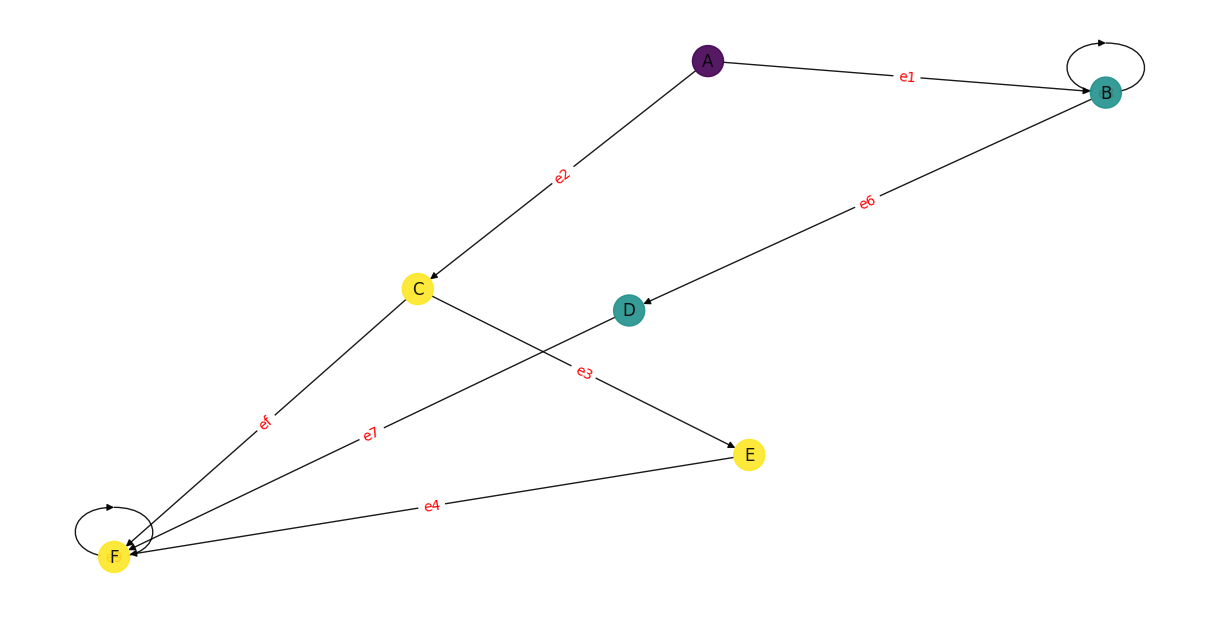

In [15]:
#We define an toy example graph to test the code
import networkx as nx

edge_labels={('A', 'B'): 'e1',  ('A', 'C'): 'e2', ('C', 'E'): 'e3', ('E', 'F'): 'e4', ('C', 'F'): 'ef', ('B', 'D'): 'e6', ('D', 'F'): 'e7'
  , ('B', 'B'): 'e8', ('F', 'F'): 'e9'
 }
all_edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'E'), ('C', 'F'),
     ('E', 'F'), ('D', 'F'),
     ('B', 'B'), ('F', 'F')
     ]

G = nx.DiGraph() # for Laplacian Matrix you can not use the directed graph
#G = nx.Graph() 
G.add_edges_from(all_edges)
    

val_map = {'A': 1.0,
           'B': 2.0,
           'C': 3.0,
           'D': 2.0, 'E': 3.0, 'F': 3.0}
#Value maps: if you want to change the color of the nodes and give same color to nodes of same class
values = [val_map.get(node, 0.25) for node in G.nodes()]

pos = nx.spring_layout(G)
plt.figure(figsize=(12,6))
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=values, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='red'
)
plt.axis('off')
plt.show()


array([[0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0]])

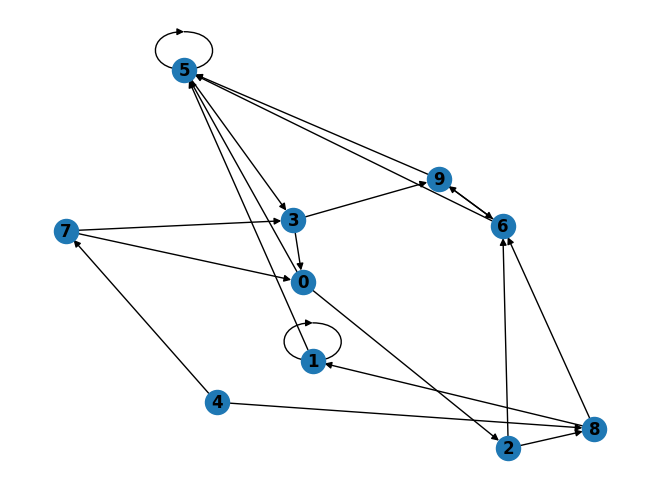

In [32]:
G = nx.random_k_out_graph(10, 2, 1, self_loops=True, seed=None)
nx.draw(G, with_labels=True, font_weight='bold')
nx.adjacency_matrix(G).todense()

In [51]:
G = nx.complete_graph(10)

In [52]:
adj = nx.adjacency_matrix(G).todense()
n_hops = 2
adj #remember ajacency matrix: for each node the row shows the connections to other nodes

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])

#from graph_utils import neighborhoods 

Returns n hop degree adjacency matrix. It takes the adjacency matrix as input and then on the number of hops :power of adjacency 
      —> If it’s not sparse: every node is a neighbor in a small number of hops (ex: undirected graph where relation is symmetric - you can go everywhere in a small number of steps)


The idea is that: nodes at more than one edge of distance (n_hops) becomes neighbors - and thus the adjacency matrix gets modified 


In [69]:
#from graph_utils import neighborhoods


def neighborhoods(adj, n_hops):
    """Returns the n_hops degree adjacency matrix adj."""

    adj = torch.tensor(adj, dtype=torch.float)
    hop_adj = power_adj = adj
    for i in range(n_hops - 1):
        power_adj = power_adj @ adj
        prev_hop_adj = hop_adj
        hop_adj = hop_adj + power_adj
        #print(type(hop_adj))
        hop_adj = (hop_adj > 0).float()
        #print(hop_adj)
    return hop_adj.cpu().numpy().astype(int)

neighborhoods(adj, n_hops)

array([[[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]]])

In [70]:
neighborhoods(adj, n_hops)[0,:] #first row shows the connections of node A to other nodes in the graph (1 means connected, 0 means not connected) 

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

# Explain function : main method

Explain a single node prediction - returns the masked adjacency matrix for the query node

(going through the node mode)
1. Extract neighborhood which returns the new index node, the adjacency matrix of the neighboor, the features of the neighboor, the label and the actual neighbors

In [73]:
#to understand we modify it a bit to get the neighborhood of a node (no graph_idx, no features)

def extract_neighborhood(adj,node_idx,n_hops, graph_idx=0):
    """Returns the neighborhood of a given ndoe."""
    neighbors_adj_row = neighborhoods(adj,n_hops)[graph_idx][node_idx, :]
    # index of the query node in the new adj
    node_idx_new = sum(neighbors_adj_row[:node_idx]) #sum of the connections of the node to the nodes before it
    neighbors = np.nonzero(neighbors_adj_row)[0]
    sub_adj = adj[graph_idx][neighbors][:, neighbors] #adjacency matrix of the neighborhood: its size depends on number of neighbors
    return node_idx_new, sub_adj,  neighbors

node_idx_new, sub_adj,  neighbors= extract_neighborhood(adj,0,10, graph_idx=0)
num_nodes = len(neighbors)
print('node_idx_new',node_idx_new)
print('sub_adj',sub_adj)
adj

node_idx_new 0
sub_adj [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


array([[[0., 1., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

- So the neighbors are indeed the neighbros as defined to be the neighbors according to the number of hops used
- the sub adj: is the adjacency matrix of the neighbors (adjacency where select only row and cols of the neighbor ) -- thus its size depends on how many neighbors the node has
- new index usually just zero

#### Then:
Then we get the original label for the node and its predicted counterpart

## We call the explainer module
1. eval the model already trained
2. Train the explainer (ExplainerModule - remember it's a nn module)
    - zero grad, optimizer, y pred and adj att prediction, mask density, .. (this should be the same ish for our scope)
3. It returns the masked adjacency matrix - which is what we kinda use as explanation??    

# Explain Module
inputs: adj, x, model, label 

get mask and mask bias -> construct edge_mask

mask and mask_bias via construct_edge_mask (line 656) - in a similar way the feature masks are initialized

->Mask are a torch.nn.parameter.Parameter object randomly initialized with dimension equal to the number of nodes in the neighborhood x number of nodes in the neighborhood (according to different initialization strategies: normal and constant are defined)

Feature mask built in a similar way : the size of the nn.Parameter is the size of the last dimension of x (and thus the number of features for the node)
Diagonal mask is a  tensor of 1s with 0s on the diagonal 

1. Forward function ( line 703 )
Masked adjacency : (_masked_asdj) is the non linear activated mask (sym_mask: it is symmetric because we add its transpose and then divide by 2) multiplied by the adjacency matrix and the diagonal mask (in this way the diagonal elements are 0s out) -> remember that the adjacency matrix we see here is the one of the neighborhood already so the shapes match 
??? So the whole idea about masking is that we perturbate the adjacency matrix  - so that the values inside the matrix are not 0s and 1s but can get different values (according to the initialization)
Then in the forward:
Ypred and adj_att are the model prediction on the node given the masked adjacency matrix (we take the softmax of the node prediction - so the result is a vector of probabilities - and we will be able to inquire how the probability of the correct class change given that we did perturb the graph)



In [74]:
#Num nodes: is how many nodes in the neighborhood (computed as the sum of 1s over the row of the node of interest - as there is a 1 only if the node is connected to other nodes)

import torch.nn as nn
import torch
import math 
def construct_edge_mask( num_nodes, init_strategy="normal", const_val=1.0):
    """
    Construct edge mask
    
    """
    mask = nn.Parameter(torch.FloatTensor(num_nodes, num_nodes))  
    if init_strategy == "normal":
        std = nn.init.calculate_gain("relu") * math.sqrt(
            2.0 / (num_nodes + num_nodes)
        )
        with torch.no_grad():
            mask.normal_(1.0, std)
            # mask.clamp_(0.0, 1.0)
    elif init_strategy == "const":
        nn.init.constant_(mask, const_val)
    return mask

def _masked_adj(mask,adj, diag_mask):
    sym_mask = mask
    sym_mask = torch.sigmoid(mask)

    sym_mask = (sym_mask + sym_mask.t()) / 2
    masked_adj = adj * sym_mask

    return masked_adj * diag_mask

def mask_density():
    mask_sum = torch.sum(torch.tensor(_masked_adj(mask,torch.tensor(sub_adj), diag_mask)))
    adj_sum = torch.sum(torch.tensor(sub_adj))
    return mask_sum / adj_sum
    
mask = construct_edge_mask( num_nodes, init_strategy="constant", const_val=1.0)
diag_mask = torch.ones(num_nodes, num_nodes) - torch.eye(num_nodes)

masked_adj = _masked_adj(mask,torch.tensor(sub_adj), diag_mask)
print('masked:', masked_adj, '\n', 'original:',sub_adj)


masked: tensor([[0.0000, 0.7311, 0.7311,  ..., 0.0000, 0.0000, 0.0000],
        [0.7311, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7311, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7311, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.7311, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64, grad_fn=<MulBackward0>) 
 original: [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_51108/2366576674.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_sum = torch.sum(torch.tensor(_masked_adj(mask,torch.tensor(sub_adj), diag_mask)))


tensor(0.7311, dtype=torch.float64)

So in ExplainModule: we define the functions to build masked adjacencies 

The forward is then defined as follows:

The method takes several arguments, but the most important one is node_idx, which appears to be the index of a node in a graph. The purpose of this method is to generate a prediction for that node, based on its features and the features of its neighbors, in the form of a softmax output.

The method first checks whether the adjacency matrix should be constrained (i.e. symmetrical) or unconstrained, and generates a masked adjacency matrix accordingly. If the mask_features flag is set, it also masks the input features. If the marginalize flag is set, it generates a random noise vector and scales it according to the feature mask.

The method then passes the masked input features and masked adjacency matrix to a model, which generates a prediction for the target node. If the graph_mode flag is set, it applies a softmax to the entire output, whereas if it is not set, it extracts the prediction for the target node and applies a softmax to that.

Finally, the method returns the softmax output and the adjacency matrix attention, which may be used for visualization or analysis purposes.

In [75]:
import torch
model = torch.load('model_experiments')

For checking the functioning of the forward we need: 
- the model - that we load (we already trained)
- adjacency matrix of interest
- node index of the node we want to explain / check its label

In [121]:


with open('adj.npy', 'rb') as f:
        adj = np.load(f)
       
with open('log/masked_adj_syn1_base_h20_o20_explainnode_idx_300graph_idx_-1.npy', 'rb') as f:
        masked_adj = np.load(f)


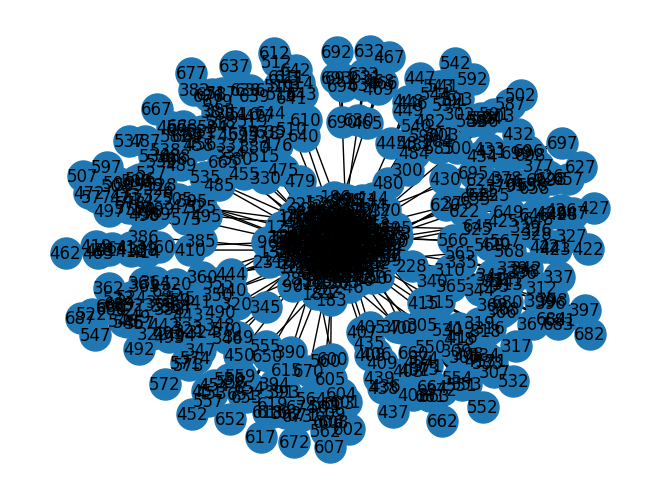

In [130]:
def show_graph_with_labels(adjacency_matrix):
    """Show graph with labels using default spring layout"""
    rows, cols = np.where(adjacency_matrix != 0)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500,  with_labels=True)
    plt.show()
show_graph_with_labels(sub_adj)     

In [124]:
node_idx_new, sub_adj,  neighbors= extract_neighborhood(adj,22,10, graph_idx=0)
num_nodes = len(neighbors)
mask = construct_edge_mask( num_nodes, init_strategy="constant", const_val=1.0)
diag_mask = torch.ones(num_nodes, num_nodes) - torch.eye(num_nodes)

masked_adj = _masked_adj(mask,torch.tensor(sub_adj), diag_mask)


In [128]:
def forward( node_idx, masked_adj,model):
    x = torch.tensor(sub_adj, dtype=torch.double)
    print(type(x))
    ypred, adj_att = model(x, masked_adj)
    node_pred = ypred[node_idx, :]
    res = nn.Softmax(dim=0)(node_pred)
    return res, adj_att

In [131]:
forward( 3, masked_adj,model)
#ok so now the problem is that the masked_adj is not the same as the one in the model
#and thus there is a shape mismatch when I try to run the model



<class 'torch.Tensor'>


RuntimeError: mat1 and mat2 shapes cannot be multiplied (700x700 and 10x20)

In [133]:
sub_adj.shape
#adj.shape

(700, 700)